# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

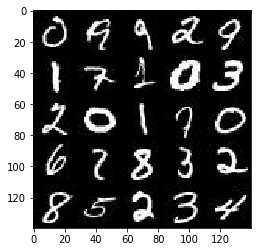

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

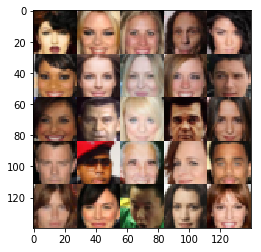

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    return (real_inputs, z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(inputs, alpha):
    return tf.maximum(inputs, alpha * inputs)

def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #28 x 28 x out_channel_dim images
    with tf.variable_scope('discriminator', reuse=reuse):
        layer0 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        layer0 = leaky_relu(layer0, alpha)
        
        layer1 = tf.layers.conv2d(layer0, 128, 5, 2, 'same')
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)

        layer2 = tf.layers.conv2d(layer1, 256, 5, 2, 'same')
        layer2 = tf.layers.batch_normalization(layer1, training=True)
        layer2 = leaky_relu(layer2, alpha)

        layer3 = tf.layers.conv2d(layer2, 512, 5, 2, 'same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3, alpha)

        flat = tf.reshape(layer3, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 7 * 7 * 512)

        layer0 = tf.reshape(x, (-1, 7, 7, 512))
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)

        layer1 = tf.layers.conv2d_transpose(layer0, 256, 5, 2, 'same')
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)

        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, 1, 'same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)

        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9)
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * 0.9)
    )
    d_loss = d_loss_real + d_loss_fake
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
PRINT_INTERVAL = 10
IMAGE_INTERVAL = 100
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    real_inputs, z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, real_inputs: batch_images, lr: learning_rate})
                if step % PRINT_INTERVAL == 0:
                    train_loss_d = d_loss.eval({z: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if step % IMAGE_INTERVAL == 0:
                    show_generator_output(sess, 16, z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.cpkt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 15.0823
Epoch 1/2... Discriminator Loss: 2.3341... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.6838... Generator Loss: 1.6259
Epoch 1/2... Discriminator Loss: 1.9373... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 2.1929... Generator Loss: 1.2401
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 1.7411
Epoch 1/2... Discriminator Loss: 2.0311... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 1.9959... Generator Loss: 1.5813
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 1.5365


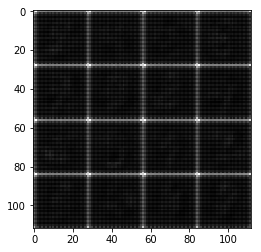

Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 1.5227
Epoch 1/2... Discriminator Loss: 1.6220... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 1.4945
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 1.3354
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.7780... Generator Loss: 0.4297
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.6282


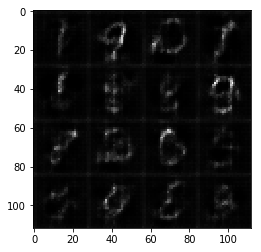

Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 1.5626
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 1.6736
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.8954
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 0.5120
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.2282
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.4629


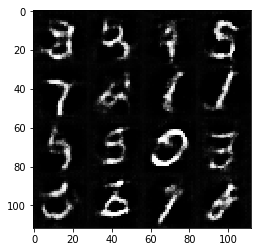

Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 1.9530... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.4629


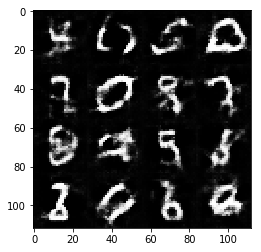

Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.4950
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 1.0506
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.5927... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.8345... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5081


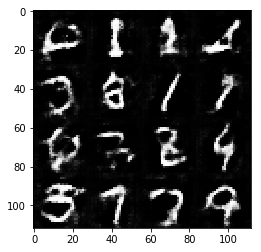

Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 1.3554
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 2.0249
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 1.5900... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 1.2508
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.4859


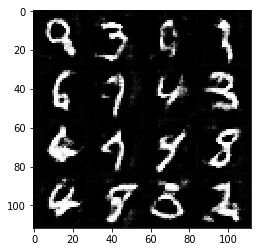

Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.6880... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.0378
Epoch 1/2... Discriminator Loss: 1.7757... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 2.2864... Generator Loss: 0.3731
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.1845


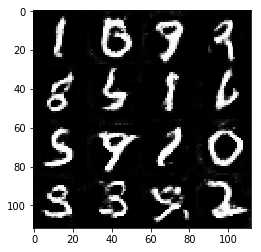

Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.8063... Generator Loss: 2.6124
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 1.5983
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.5299
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.4749


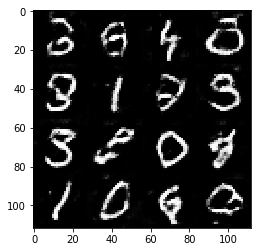

Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 2.0978
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.6247... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 2.0641... Generator Loss: 0.3928
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 2.4519... Generator Loss: 0.3581
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.9746


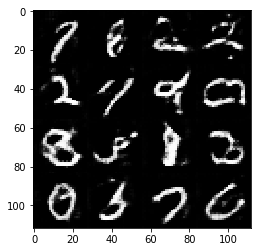

Epoch 1/2... Discriminator Loss: 1.8382... Generator Loss: 0.4221
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.5155... Generator Loss: 0.5080
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.3117
Epoch 2/2... Discriminator Loss: 1.5197... Generator Loss: 2.3011


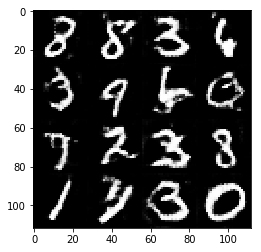

Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 2.2071... Generator Loss: 0.3831
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 1.9902
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 1.8735
Epoch 2/2... Discriminator Loss: 1.6945... Generator Loss: 0.5449


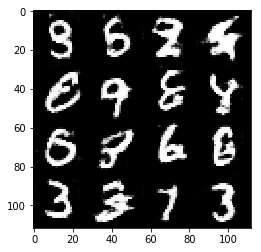

Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.7647... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.5999
Epoch 2/2... Discriminator Loss: 1.6773... Generator Loss: 2.3476
Epoch 2/2... Discriminator Loss: 1.5560... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.6817


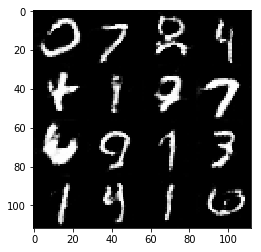

Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 1.8004
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 1.7718... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.7915
Epoch 2/2... Discriminator Loss: 1.5018... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 2.2713


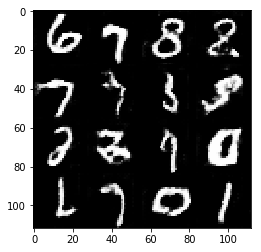

Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.3733
Epoch 2/2... Discriminator Loss: 1.6659... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 1.5223... Generator Loss: 2.3540
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 1.7269... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.6905


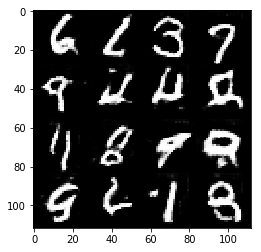

Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.7070
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 1.9183
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.6949... Generator Loss: 2.7149
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 2.1236
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 1.2194


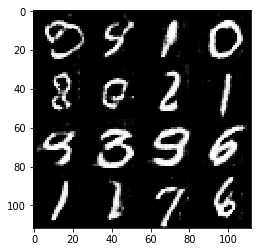

Epoch 2/2... Discriminator Loss: 1.5859... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 0.8993
Epoch 2/2... Discriminator Loss: 1.6617... Generator Loss: 0.5094
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 2.1612
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.3183
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.0034
Epoch 2/2... Discriminator Loss: 1.5236... Generator Loss: 0.5178


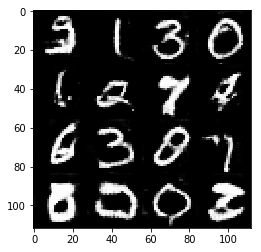

Epoch 2/2... Discriminator Loss: 1.8870... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 1.9993... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.8323
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.3308
Epoch 2/2... Discriminator Loss: 1.8426... Generator Loss: 0.4853
Epoch 2/2... Discriminator Loss: 1.5529... Generator Loss: 0.5472


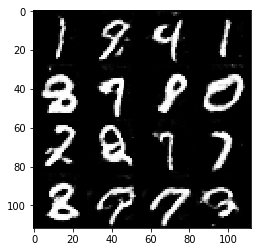

Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.2724
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.9388... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 1.5111
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.9823
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.8867
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.9533
Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 2.8008
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 1.4894


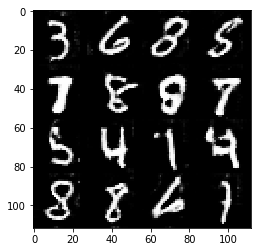

Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 1.7399... Generator Loss: 2.0172
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6632


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.0147... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 2.6692... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 3.8597
Epoch 1/1... Discriminator Loss: 3.3430... Generator Loss: 5.5136
Epoch 1/1... Discriminator Loss: 2.2319... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 1.8483
Epoch 1/1... Discriminator Loss: 2.0472... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.8553


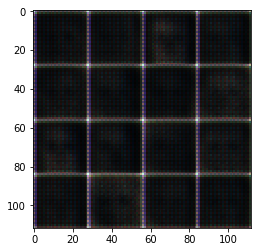

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 2.2065... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5547


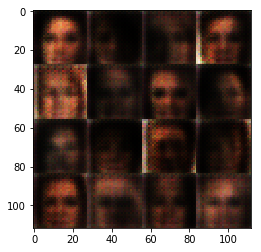

Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.7255
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.7544


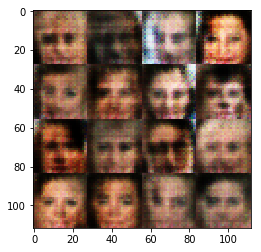

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.7000... Generator Loss: 2.1334
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 2.1485
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.7643
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.8090


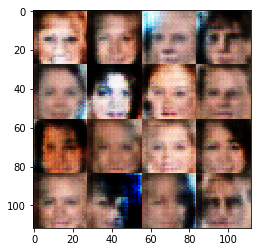

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 2.7542
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.8049... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6822


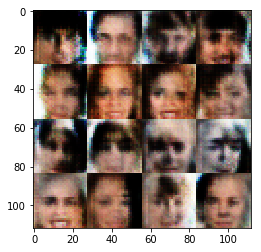

Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.6432


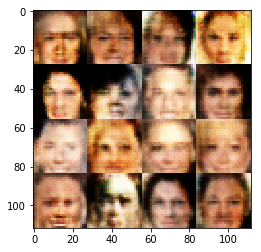

Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 2.0484
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.7100
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 2.1630... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.1162


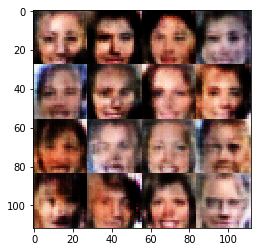

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.8786
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5206


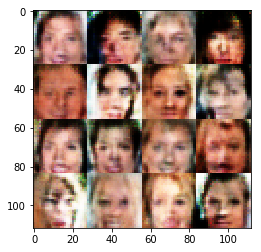

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 3.0545... Generator Loss: 3.0452
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.1423
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.3893


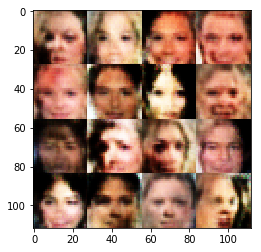

Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 2.5956
Epoch 1/1... Discriminator Loss: 2.3776... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6952


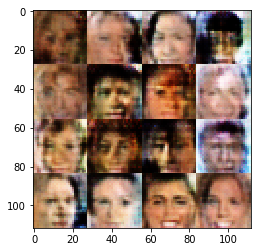

Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 2.6703
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 2.0836
Epoch 1/1... Discriminator Loss: 2.6122... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.0928


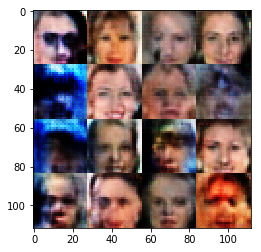

Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 2.6984
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 2.6782
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0129


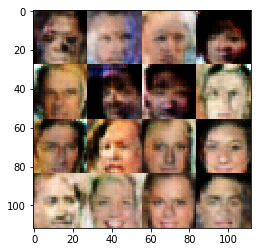

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.7654... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 2.0080
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.2590


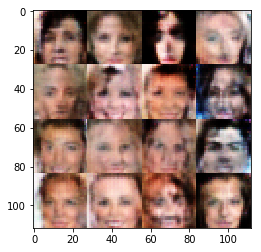

Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.7301


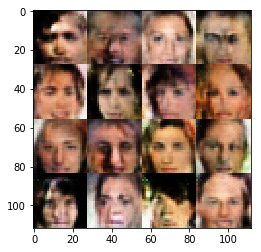

Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 2.7327
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 3.4481... Generator Loss: 4.9378
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.9893


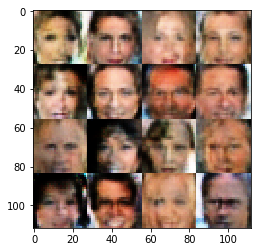

Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.9055... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 2.1979... Generator Loss: 3.3479
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.8790


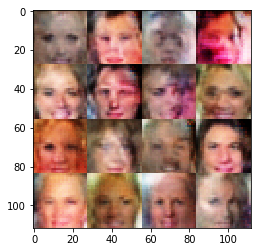

Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 2.6593
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 2.1400
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.8288


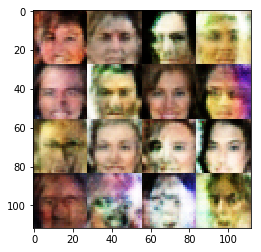

Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 2.0007
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 2.0578... Generator Loss: 0.3812


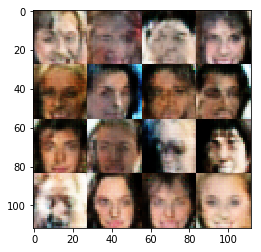

Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 3.2199
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.7610


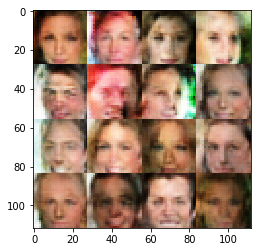

Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 2.7188
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.9811... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.2391


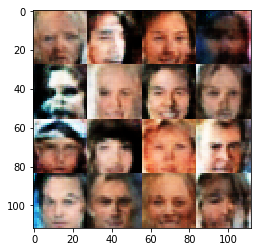

Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 3.1140
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.6657
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.9289


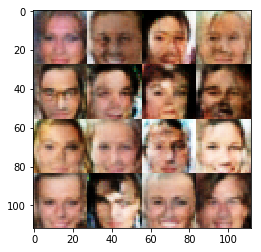

Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.8755
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 2.1528


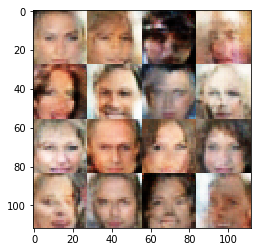

Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.7660... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.7958


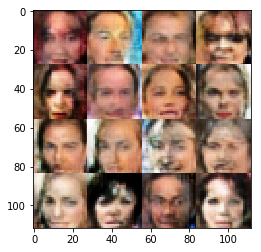

Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 2.4864... Generator Loss: 2.8344
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.9633... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.9774... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 1.9109


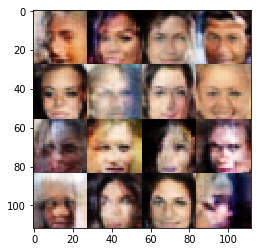

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.7161
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.1287


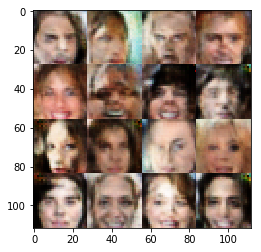

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.7463


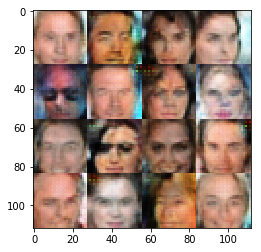

Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.9434... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.6425
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.1194


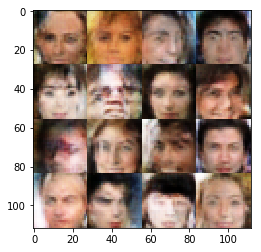

Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5988


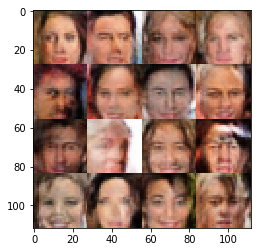

Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9137


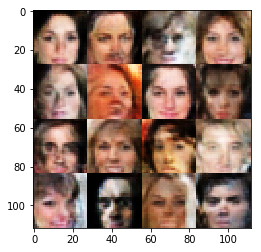

Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 2.5223
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.3593


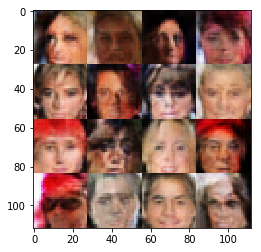

Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8943


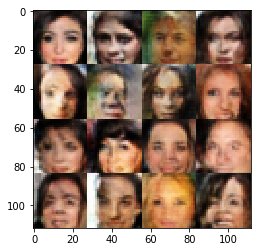

Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.9180


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.